# Winter 2015-16
12/22/2015 - 3/20/2016

In [51]:
from __future__ import print_function

import random
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [52]:
week_list = ['151219','151226','160102','160109','160116','160123','160130',
             '160206','160213','160220','160227','160305','160312','160319']
weeks = []
for week in random.sample(week_list,4):
    string = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + week + '.txt'
    weeks.append(pd.read_csv(string).rename(columns=lambda x: x.strip()))
    
data = pd.concat(weeks)
data = data.reset_index()

In [53]:
data.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,03:00:00,REGULAR,5583673,1884949
1,1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,07:00:00,REGULAR,5583689,1884968
2,2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,11:00:00,REGULAR,5583785,1885067
3,3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,15:00:00,REGULAR,5584037,1885157
4,4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,19:00:00,REGULAR,5584482,1885250


In [54]:
data['DATETIME'] = pd.to_datetime(data.DATE + data.TIME, format='%m/%d/%Y%H:%M:%S')

PERIOD is a variable that splits the day into 6 distinct sections. This is to account for the differences in times that the counts are recorded.

In [55]:
data['HOUR'] = data.DATETIME.map(lambda x: x.hour)
data['PERIOD'] = data.HOUR // 4

In [56]:
data['dENTRIES'] = data.groupby(['C/A','UNIT','SCP','STATION']).ENTRIES.diff()
data['dEXITS'] = data.groupby(['C/A','UNIT','SCP','STATION']).EXITS.diff()

In [57]:
# Anything over 6000 is probably an error
data = data[data.dENTRIES >= 0]
data = data[data.dEXITS >= 0]
data = data[data.dENTRIES <= 5000]
data = data[data.dEXITS <= 5000]

data['FLUX'] = data.dENTRIES + data.dEXITS

In [58]:
data.describe()

,index,ENTRIES,EXITS,HOUR,PERIOD,dENTRIES,dEXITS,FLUX
count,748652.000000,7.486520e+05,7.486520e+05,748652.000000,748652.000000,748652.000000,748652.000000,748652.000000
mean,96745.486587,2.365579e+07,1.740944e+07,11.697194,2.557001,188.103067,141.091289,329.194356
std,55794.958390,1.463633e+08,1.237205e+08,6.837364,1.672125,281.581987,248.421651,424.861500
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48374.000000,5.548380e+05,2.863025e+05,7.000000,1.000000,10.000000,8.000000,32.000000
50%,96756.000000,2.446814e+06,1.440294e+06,12.000000,3.000000,76.000000,50.000000,171.000000
75%,145055.000000,6.225964e+06,4.397877e+06,17.000000,4.000000,255.000000,166.000000,475.000000
max,194775.000000,2.146697e+09,2.097164e+09,23.000000,5.000000,4968.000000,4961.000000,9333.000000


In [59]:
# Far more entries than exits. Possibly accounted for by 'emergency exits' and/or human sacrifice
print(sum(data.dENTRIES))
print(sum(data.dEXITS))

140823737.0
105628276.0


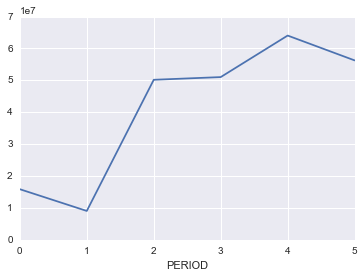

In [72]:
times = data.groupby('PERIOD').sum()
times.FLUX.plot()

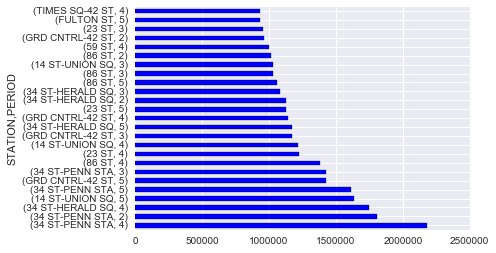

In [68]:
times = data.groupby(['STATION','PERIOD']).sum()
times.FLUX.sort_values(ascending=False)[:25].plot.barh()

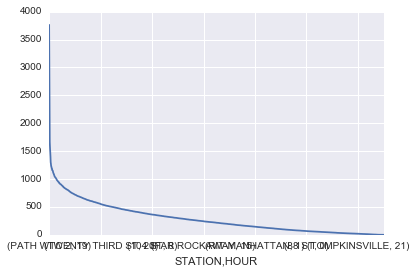

In [60]:
times = data.groupby(['STATION','HOUR']).median()
times.FLUX.sort_values(ascending=False).plot.line()

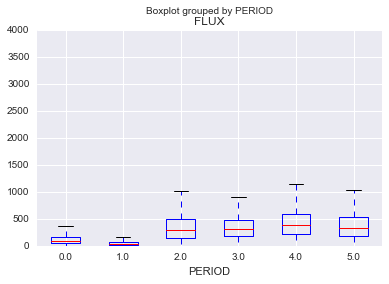

In [61]:
times.boxplot(column='FLUX',by='PERIOD')

In [63]:
geo_names = ['UNIT','C/A','STATION','X','DIVISION','LAT','LON']
geocodes = pd.read_csv('geocoded.csv', names = geo_names)
geocodes = geocodes.drop('X',1)
geocodes.head()

,UNIT,C/A,STATION,DIVISION,LAT,LON
0,R470,X002,ELTINGVILLE PK,SRT,40.544600,-74.164581
1,R544,PTH02,HARRISON,PTH,40.738879,-74.155533
2,R165,S102,TOMPKINSVILLE,SRT,40.636948,-74.074824
3,R070,S101,ST. GEORGE,SRT,40.643738,-74.073622
4,R070,S101A,ST. GEORGE,SRT,40.643738,-74.073622


In [64]:
data = pd.merge(data,geocodes,how='left',on=['C/A','UNIT','STATION','DIVISION'])

In [65]:
times.head()

index    ENTRIES       EXITS  PERIOD  dENTRIES  dEXITS   FLUX
STATION HOUR                                                               
1 AV    0     29488  7552572.0  11819860.0       0     344.0   210.0  896.0
        3     30017  7474767.0  11606963.0       0     101.0    73.0  245.0
        4     29486  7551791.5  11817681.5       1      53.0    17.5  118.0
        7     29999  7472432.5  11605209.5       1      44.5    71.5  151.5
        8     29502  7552751.0  11816408.0       2     130.0   191.0  407.0

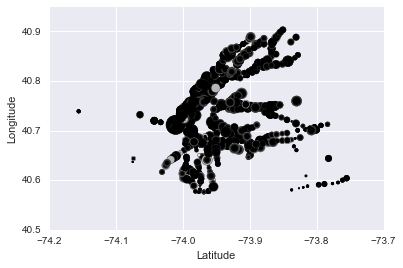

In [66]:
times = data.groupby(['STATION','HOUR']).median()
fig, ax = plt.subplots()
ax.scatter(times.LON,times.LAT,s=(times.FLUX)/10,c=times.PERIOD)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [71]:
import gmaps

geodata = data.as_matrix(columns=['LON','LAT','FLUX'])
maps = gmaps.heatmap(geodata)
gmaps.display(maps)
geodata

ValueError: Google Maps only support positive weights.